#**Text classification with preprocessed text: Movie reviews**

In [1]:
import tensorflow as tf
from tensorflow import keras
!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
if tf.__version__ != '2.0.0':
  !pip install tensorflow==2.0.0
  print("** Tensorflow updated **")
print("Tensorflow version : ",tf.__version__)

Tensorflow version :  2.0.0


#**Download the IMDB dataset**
It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [2]:
(trainData, testData), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k',
    # Return the train/test datasets as a tuple
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised = True,
    # Also return the `info` structure. 
    with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


#**Try the encoder**
The dataset info includes the text encoder (a tfds.features.text.SubwordTextEncoder).

In [0]:
encoder = info.features['text'].encoder

In [4]:
print("Vocabulary size : {}".format(encoder.vocab_size))

Vocabulary size : 8185


This text encoder will reversibly encode any string:

In [5]:
sampleString = "Hello Tensorflow"
encodedString = encoder.encode(sampleString)
print("Encoded string : {}".format(encodedString))
originalString = encoder.decode(encodedString)
print("The original string : {}".format(originalString))

#assert originalString == sampleString


Encoded string : [4025, 222, 6307, 2327, 2934]
The original string : Hello Tensorflow


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [6]:
for ts in encodedString:
  print("{} --> {}".format(ts, encoder.decode([ts])))

4025 --> Hell
222 --> o 
6307 --> Ten
2327 --> sor
2934 --> flow


#**Explore the data**
* Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review.
* The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary.
* Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [7]:
for trainExample, trainLabel in trainData.take(1):
  print("Encoding text : {]}",trainExample[:10].numpy())
  print("Label : ",trainLabel.numpy())

Encoding text : {]} [ 249    4  277  309  560    6 6639 4574    2   12]
Label :  1


In [8]:
encoder.decode(trainExample)

"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dickens

#**Prepare the data for training**
The reviews are all different lengths, so use padded_batch to zero pad the sequences while batching:

In [0]:
BUFFER_SIZE = 1000
trainBatches = (trainData.shuffle(BUFFER_SIZE).padded_batch(32, trainData.output_shapes))
testBatches = testData.padded_batch(32, trainData.output_shapes)

Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length:

In [10]:
for exampleBatch, labelBatch in trainBatches.take(2):
  print("Batch shape : ",exampleBatch.shape)
  print("Label : ",labelBatch.shape)

Batch shape :  (32, 1031)
Label :  (32,)
Batch shape :  (32, 1084)
Label :  (32,)


#**Build the model**
In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a "Continuous bag of words" style model for this problem

In [11]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


##The layers are stacked sequentially to build the classifier:
1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.



###Hidden units
If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called overfitting, and we'll explore it later.

#**Loss function and optimizer**

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', # mean_squared_error
              metrics=['accuracy'])

#**Train the model**

In [13]:
history = model.fit(trainBatches,
                   epochs=10,
                   validation_data=testBatches,
                   validation_steps=30)

Epoch 1/10
782/782 [==============================] - 14s 18ms/step - loss: 0.6823 - accuracy: 0.6257 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 0.6258 - accuracy: 0.7499 - val_loss: 0.6011 - val_accuracy: 0.7625
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 0.5476 - accuracy: 0.8018 - val_loss: 0.5341 - val_accuracy: 0.8083
Epoch 4/10
782/782 [==============================] - 11s 14ms/step - loss: 0.4797 - accuracy: 0.8388 - val_loss: 0.4794 - val_accuracy: 0.8250
Epoch 5/10
782/782 [==============================] - 11s 14ms/step - loss: 0.4280 - accuracy: 0.8629 - val_loss: 0.4379 - val_accuracy: 0.8604
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.3851 - accuracy: 0.8737 - val_loss: 0.4042 - val_accuracy: 0.8604
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.3548 - accuracy: 0.8848 - val_loss: 0.3802 - val_a

#**Evaluate the model**
And let's see how the model performs

In [14]:
loss, accuracy = model.evaluate(testBatches)
print("Loss : ",loss)
print("Accuracy : ",accuracy)


782/782 [==============================] - 9s 12ms/step - loss: 0.3345 - accuracy: 0.8734
Loss :  0.3344910777533603
Accuracy :  0.87344


#**Create a graph of accuracy and loss over time**

In [15]:
historyDict = history.history
historyDict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy

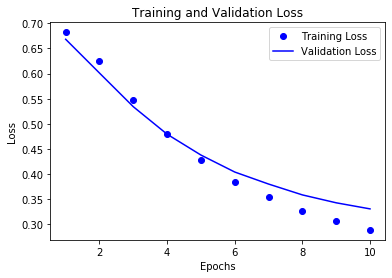

In [16]:
import matplotlib.pyplot as plt

acc = historyDict['accuracy']
valAcc = historyDict['val_accuracy']
loss = historyDict['loss']
valLoss = historyDict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training Loss') # 'bo' is for blue dot
plt.plot(epochs, valLoss, 'b', label='Validation Loss') # 'b' is for solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() # graph information
plt.show()



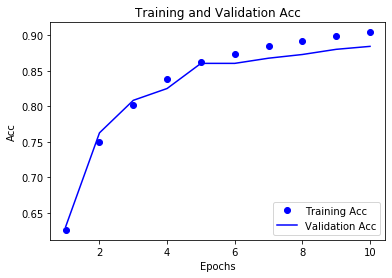

In [17]:
plt.clf() # clear figure

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, valAcc, 'b', label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.show()


This is an example of **overfitting**. The model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

#**The End**